In [1]:
import json
import pandas as pd

import pymongo
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
def reduce_mem_usage(df, verbose=False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
import numpy as np
 
class Performance:
    """
    定义一个类，用来分类器的性能度量
    """
    def __init__(self, labels, scores, threshold=0.5):
        """
        :param labels:数组类型，真实的标签
        :param scores:数组类型，分类器的得分
        :param threshold:检测阈值
        """
        self.labels = labels
        self.scores = scores
        self.threshold = threshold
        self.db = self.get_db()
        self.TP, self.FP, self.FN, self.TN = self.get_confusion_matrix()
 
    def accuracy(self):
        """
        :return: 正确率
        """
        return (self.TP + self.TN) / (self.TP + self.FN + self.FP + self.TN)
 
    def presision(self):
        """
        :return: 准确率
        """
        if (self.TP + self.FP) == 0:
            return 0
        return self.TP / (self.TP + self.FP)
    
    def presision2(self):
        """
        :return: 准确率
        """
        if (self.TN + self.FN) == 0:
            return 0
        return self.TN / (self.TN + self.FN)
    
    def get_db(self):
        db = []
        for i in range(len(self.labels)):
            db.append([self.labels[i], self.scores[i]])
        db = sorted(db, key=lambda x: x[1], reverse=True)
        return db

    def get_confusion_matrix(self):
        """
        计算混淆矩阵
        :return:
        """
        tp, fp, fn, tn = 0., 0., 0., 0.
        for i in range(len(self.labels)):
            if self.labels[i] == 1 and self.scores[i] >= self.threshold:
                tp += 1
            elif self.labels[i] == 0 and self.scores[i] >= self.threshold:
                fp += 1
            elif self.labels[i] == 1 and self.scores[i] < self.threshold:
                fn += 1
            else:
                tn += 1
        return [tp, fp, fn, tn]

In [4]:
def getGoalMid(masterGoal, guestGoal, masterMidGoal, guestMidGoal):
    return int(masterGoal) + int(guestGoal) - int(masterMidGoal) - int(guestMidGoal)


def removeSub(pankou):
    pankou = pankou.replace("升", "")
    pankou = pankou.replace("降", "")
    return pankou.strip()


def getResultOne(goalMid, pankou):
    row = pankou
    row = 0
    if goalMid - float(row) > 0:
        return 1
    if goalMid - float(row) <= 0:
        return 0
    
def getType(yapanMasterStartOdd, yapanGuestStartOdd, yapanPankouStart):
    linTypeStart = get18(yapanMasterStartOdd, yapanGuestStartOdd)
    return str(linTypeStart)


def get18(master, guest):
    if master > guest:
        return 18
    if master < guest:
        return 81
    if master == guest:
        return 99


def daxiao_num(x):
    x_list = x.split("/")
    num = 0
    for i in x_list:
        num += float(i)
    return (float(num)/len(x_list))

def daxiao_num_bifeng(x):
    x_list = x.split("-")
    num = 0
    for i in x_list:
        num += float(i)
    return (float(num)/len(x_list))

def realDaxiao(x, master, guest):
    return float(x) - float(master) - float(guest)

def realDaxiao75(x, last):
    master = last.split("-")[0]
    guest = last.split("-")[1]
    return float(x) - float(master) - float(guest)

def shengjiang(start, end):
    return ((end) - (start))

def round2(x):
    return round((x), 2)

In [5]:
def getShuiPing(x):
    result = 11
    if x < 0.75:
        result = 0
    if 0.75<= x and x<=0.85:
        result = 1
    if 0.85<x and x<=0.90:
        result = 2
    if 0.90<x and x<=0.95:
        result = 3
    if 0.95<x and x<=1.00:
        result = 4
    if 1.00<x and x<=1.08:
        result = 5
    if 1.08<x:
        result = 6
    return result

def num_fea_dis(df,features):
    for f in features:
        nm = f+'_'+'shuiPing'
        df[nm] = df[f].map(getShuiPing)
    return df

In [6]:
def getLastTime(x):
    if x >= 45 and x < 50 :
        return 0 
    if x >= 50 and x < 60 :
        return 1 
    if x >= 60 and x <= 75:
        return 2
    return 3

def getResult65(zhong,last):
    sum1 = 0
    for i in zhong.split('-'):
        sum1 += int(i)
    sum2 = 0
    for i in last.split('-'):
        sum2 += int(i)
    return sum2 - sum1

def getResult(result1,result2,time):
    if time > 75:
        return result1
    return result2

def getResultNew(x):
    if x >= 1:
        return 1
    return 0

def pankouFlow(x,y):
    return float(x) - float(y)

In [7]:
def fillNa(x, value):
    if pd.isnull(x):
        return value
    else:
        return x

    
def preF(test):
    test['goalMid'] = test.apply(lambda x: getGoalMid(
        x['masterGoal'], x['guestGoal'], x['midGuestGoal'], x['midMasterGoal']), axis=1)
    
    test = test[test['goalMid'] >= 0]
    
    test['bifeng'] = test['masterGoal'].astype(
        str) + "-" + test['guestGoal'].astype(str)
    
    test['zhongbifengNew'] = test['midMasterGoal'].astype(
        str) + "-" + test['midGuestGoal'].astype(str)
    
    test['allbifeng'] = test['lastBifeng'].astype(
        str) + "-" + test['zhongbifengNew'].astype(str)

    pankou = ["pankouOdd_End_Zhong_3","pankou_Start_Zhong_3"] + ["pankou_Start_Ji_3","pankouOdd_End_Ji_3"]

    for col in pankou:
        test[col] = test[col].astype(str)
        test[col] = test[col].map(daxiao_num)
        test[col+"daxiao"] = test[col]
        test[col] = test[col].astype(str)
        nm = col + "Real"
        test[nm] = test.apply(lambda x: realDaxiao(x[col],x['midGuestGoal'],x['midMasterGoal']), axis=1)
        test[nm] = test[nm].astype(str)
        
    test['allbifengNew'] = test['allbifeng'].astype(
        str) + "-" + test['pankouOdd_End_Zhong_3Real'].astype(str) + "-" + test['pankouOdd_End_Ji_3'].astype(str)
    
    fes = ['masterOdd_Start_Ji_3', 'masterOdd_End_Ji_3',
           'masterOdd_Start_Zhong_3', 'masterOdd_End_Zhong_3'] + ['guestOdd_Start_Ji_3', 'guestOdd_End_Ji_3',
           'guestOdd_Start_Zhong_3', 'guestOdd_End_Zhong_3']
    
    
    num_fea_dis(test, fes)
    
    test['daxiaoTypeStart'] = test.apply(lambda x: getType(x['masterOdd_Start_Ji_3'], x['guestOdd_Start_Ji_3'],x['pankou_Start_Ji_3']), axis=1)
    test['daxiaoType'] = test.apply(lambda x: getType(x['masterOdd_End_Ji_3'], x['guestOdd_End_Ji_3'],x['pankouOdd_End_Ji_3']), axis=1)
    test['daxiaoTypeStartMid'] = test.apply(lambda x: getType(x['masterOdd_Start_Zhong_3'], x['guestOdd_Start_Zhong_3'],x['pankou_Start_Zhong_3Real']), axis=1)
    test['daxiaoTypeMid'] = test.apply(lambda x: getType(x['masterOdd_End_Zhong_3'], x['guestOdd_End_Zhong_3'],x['pankouOdd_End_Zhong_3Real']), axis=1)
    
    test["daxiaoTypeCompare"] = test["daxiaoType"] == test["daxiaoTypeMid"]

    test['daxiaoTypeStart'] = test['masterOdd_Start_Ji_3_shuiPing'].astype(str) + test['daxiaoTypeStart']
    test['daxiaoType'] = test['masterOdd_End_Ji_3_shuiPing'].astype(str) + test['daxiaoType']
    
    test['daxiaoTypeStartMid'] = test['masterOdd_Start_Zhong_3_shuiPing'].astype(str) + test['daxiaoTypeStartMid']
    test['daxiaoTypeMid'] = test['masterOdd_End_Zhong_3_shuiPing'].astype(str) + test['daxiaoTypeMid']
 
    test['daxiaoTypeALL'] = test['daxiaoTypeStart'] + test['daxiaoType']
    test['daxiaoTypeMidALL'] = test['daxiaoTypeStartMid'] + test['daxiaoTypeMid'] + test['zhongbifengNew']
    
    test['daxiaoPankou'] = test['pankou_Start_Ji_3'] + test['pankouOdd_End_Ji_3']
    test['daxiaoPankouMid'] = test['pankou_Start_Zhong_3Real'] + test['pankouOdd_End_Zhong_3Real']
    test['daxiaoPankouALL'] = test['daxiaoPankou'] + test['daxiaoPankouMid'] + test['zhongbifengNew']

    test['MasterOddFlowPankou'] = test["pankouOdd_End_Ji_3"].astype(float) - test["pankou_Start_Ji_3"].astype(float)
    test['MasterOddFlowPankouMid'] = test["pankou_Start_Zhong_3"].astype(float) - test["pankouOdd_End_Zhong_3"].astype(float)
    test['MasterOddFlow'] = test["masterOdd_Start_Ji_3"] - test["masterOdd_End_Ji_3"]
    
    test['daxiaoTypeStartMidLast'] = test['masterOdd_Start_Zhong_3_shuiPing'].astype(str) + test['daxiaoTypeStartMid'] + test['lastBifeng'].astype(str)
    test['daxiaoTypeMidLast'] = test['masterOdd_End_Zhong_3_shuiPing'].astype(str) + test['daxiaoTypeMid'] + test['lastBifeng'].astype(str)
    test['daxiaoTypeStartLast'] = test['masterOdd_Start_Ji_3_shuiPing'].astype(str) + test['daxiaoTypeStart'] + test['lastBifeng'].astype(str)
    test['daxiaoTypeLast'] = test['masterOdd_End_Ji_3_shuiPing'].astype(str) + test['daxiaoType'] + test['lastBifeng'].astype(str)
    test['daxiaoPankouLast'] = test['pankou_Start_Ji_3'] + test['pankouOdd_End_Ji_3'] + test['lastBifeng'].astype(str)
    test['daxiaoPankouMidLast'] = test['pankou_Start_Zhong_3Real'] + test['pankouOdd_End_Zhong_3Real'] + test['lastBifeng'].astype(str)
    test['daxiaoPankouALLLast'] = test['daxiaoPankou'] + test['daxiaoPankouMid'] + test['zhongbifengNew'] + test['lastBifeng'].astype(str)
        
#     test = test.drop(['masterOdd_Start_Ji_3_shuiPing', 'masterOdd_End_Ji_3_shuiPing',
#                       'masterOdd_Start_Zhong_3_shuiPing','masterOdd_End_Zhong_3_shuiPing'], axis=1)
    
#     test = test.drop(['guestOdd_Start_Ji_3_shuiPing', 'guestOdd_End_Ji_3_shuiPing',
#                       'guestOdd_Start_Zhong_3_shuiPing','guestOdd_End_Zhong_3_shuiPing'], axis=1)
    
    test = test.drop(columns=['masterGoal', 'guestGoal', "goalMid"])
    test = test.drop(columns=['midGuestGoal', 'midMasterGoal'])
#     test = test.drop(columns=['time'])

    test["lastTime"] = test["lastTime"].astype(int)
    test["lastTime75"] = test["lastTime75"].astype(int)
    test["lastTime130"] = test["lastTime130"].astype(int)
    
    test["lastTimeSub"] = test["lastTime75"] - test["lastTime"]
    test["lastTimeSub130"] = test["lastTime130"] - test["lastTime75"]
    
    test["result1"] =  test.apply(lambda x: getResult65(x['lastBifeng130'], x['bifeng']), axis=1)
    test["result2"] =  test.apply(lambda x: getResult65(x['lastBifeng752'], x['bifeng']), axis=1)
    test["result"] =  test.apply(lambda x: getResult(x['result1'], x['result2'],x['lastTime130']), axis=1)
    test = test[test["result"] >= 0]
    test["result"] = test["result"].map(getResultNew)
    test = test.drop(["bifeng","result1","result2"], axis=1)
    
    test['lastBifengNum'] = test['lastBifeng'].map(daxiao_num_bifeng)
    test['lastBifeng130Num'] = test['lastBifeng130'].map(daxiao_num_bifeng)
    test = test[test['lastBifengNum']<=test['lastBifeng130Num']]
    
#     test = test[test['masterOdd_End_130_3']<=1.5]

#     test =  test[test["lastTime75"] != test["lastTime"]]
#     test = test[(test["lastTime"] <= 75) & (test["lastTime"] >= 45)]
#     test = test[test['lastBifeng']==test['lastBifeng130']]

#     test["result"] =  test.apply(lambda x: getResult65(x['lastBifeng'], x['bifeng']), axis=1)
#     test =  test[test["lastTime75"] != test["lastTime130"]]
#     test["result75"] =  test.apply(lambda x: getResult65(x['lastBifeng'], x['lastBifeng130']), axis=1)
#     test = test[test["result75"] == 0]

#     test = test.drop(['guestOdd_Start_75_3', 'masterOdd_End_75_3',
#                       'guestOdd_Start_130_3','guestOdd_End_130_3'], axis=1)
    
#     test = test[test["result"] >= 0]

#     test["pankouOdd_End_Zhong_3Real"] = test["pankouOdd_End_Zhong_3Real"].astype(float)
    return test

In [8]:
def realDaxiao75(x, last):
    master = last.split("-")[0]
    guest = last.split("-")[1]
    return float(x) - float(master) - float(guest)

def pref65(test,time):
    pankou = ["pankouOdd_End_"+time+"_3"]

    for col in pankou:
        test[col] = test[col].astype(str)
        test[col] = test[col].map(daxiao_num)
        test[col+"daxiao"] = test[col]
        test[col] = test[col].astype(str)

    fes = ['masterOdd_End_'+time+"_3",'guestOdd_End_'+time+"_3"]
    
    num_fea_dis(test, fes)
    
        
    test['daxiaoType'+time] = test.apply(lambda x: getType(x['masterOdd_End_'+time+"_3"], x['guestOdd_End_'+time+"_3"],x['pankouOdd_End_'+time+"_3"]), axis=1)
    test['daxiaoType'+time] = test['masterOdd_End_'+time+"_3_shuiPing"].astype(str) + test['daxiaoType'+time]
    test["pankouOdd_End_"+time+"_real2"] =  test.apply(lambda x: realDaxiao75(x['pankouOdd_End_'+time+"_3"], x['lastBifeng'+time]), axis=1)
    
    test["daxiaoType"+time+"odd"] = test['lastBifeng'+time] + test['masterOdd_End_'+time+"_3"].astype(str) + test["pankouOdd_End_"+time+"_real2"].astype(str) + test['guestOdd_End_'+time+"_3"].astype(str)
    
#     test = test.drop(['masterOdd_End_'+time+"_3_shuiPing",'guestOdd_End_'+time+"_3_shuiPing"], axis=1)

    return test

In [9]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["soccerData"]
mycol = mydb["win007Lastv1006-4"]
data_mid = pd.DataFrame(list(mycol.find({"time":{"$gte":"2016-01-01 00:00:00","$lt":"2022-01-01 00:00:00"}})))
data_mid = data_mid.drop(['_id','place'], axis=1)
data_mid = data_mid.dropna()
data_mid = reduce_mem_usage(data_mid)
# data_mid = data_mid[data_mid["lastTime"]!="中场"]
print(data_mid.shape)
data_mid = preF(data_mid)
for time in ["60","752","130","75"]:
    data_mid = pref65(data_mid,time)
print(data_mid.shape)
# data_mid.to_csv('data_mid.txt')
#1006-4是进一个球的

(150976, 38)
(147503, 102)


In [10]:
train = data_mid

train.to_csv("train_5.txt")

In [11]:
train.head()

,lianShai,time,guestOdd_End_130_3,guestOdd_End_60_3,guestOdd_End_752_3,guestOdd_End_75_3,guestOdd_End_Ji_3,guestOdd_End_Zhong_3,guestOdd_Start_Ji_3,guestOdd_Start_Zhong_3,...,guestOdd_End_130_3_shuiPing,daxiaoType130,pankouOdd_End_130_real2,daxiaoType130odd,pankouOdd_End_75_3daxiao,masterOdd_End_75_3_shuiPing,guestOdd_End_75_3_shuiPing,daxiaoType75,pankouOdd_End_75_real2,daxiaoType75odd
0,澳女联,2019-01-10 16:30:00,0.76,0.88,0.89,1.06,1.17,0.76,1.08,1.00,...,1,518,0.5,3-01.040.50.76,2.5,0,5,081,0.5,2-00.740.51.06
1,西联杯,2019-01-10 19:00:00,0.78,0.72,0.81,1.07,1.03,1.00,1.03,1.00,...,1,518,0.5,1-21.020.50.78,3.5,0,5,081,0.5,1-20.730.51.07
2,球会友谊,2019-01-10 21:00:00,0.86,0.81,0.94,1.03,1.03,0.83,0.93,0.85,...,2,418,0.5,0-11.00.50.86,1.5,1,5,181,0.5,0-10.830.51.03
3,亚洲杯,2019-01-10 19:00:00,0.85,0.72,0.91,1.11,0.94,1.01,0.94,1.00,...,1,518,0.5,0-11.010.50.85,1.5,1,6,181,0.5,0-10.760.51.11
4,球会友谊,2019-01-10 23:00:00,0.85,0.96,0.88,1.11,0.90,0.81,1.06,0.90,...,1,518,0.5,1-01.010.50.85,1.5,1,6,181,0.5,1-00.760.51.11


In [12]:
test = pd.DataFrame(list(mycol.find({"time":{"$gte":"2022-01-01 00:00:00","$lt":"2023-01-01 00:00:00"}})))
test = test.dropna()
# test = test[test["lastTime"]!="中场"]
test = test.drop(['_id','place'], axis=1)
print(test.shape)
test = preF(test)
for time in ["60","752","130","75"]:
    test = pref65(test,time)
print(test.shape)

(21976, 38)
(21773, 102)


In [13]:
pd.set_option('display.max_columns', None)
test.head()

,lianShai,time,guestOdd_End_130_3,guestOdd_End_60_3,guestOdd_End_752_3,guestOdd_End_75_3,guestOdd_End_Ji_3,guestOdd_End_Zhong_3,guestOdd_Start_Ji_3,guestOdd_Start_Zhong_3,lastBifeng,lastBifeng130,lastBifeng60,lastBifeng75,lastBifeng752,lastTime,lastTime130,lastTime75,masterOdd_End_130_3,masterOdd_End_60_3,masterOdd_End_752_3,masterOdd_End_75_3,masterOdd_End_Ji_3,masterOdd_End_Zhong_3,masterOdd_Start_Ji_3,masterOdd_Start_Zhong_3,pankouOdd_End_130_3,pankouOdd_End_60_3,pankouOdd_End_752_3,pankouOdd_End_75_3,pankouOdd_End_Ji_3,pankouOdd_End_Zhong_3,pankou_Start_Ji_3,pankou_Start_Zhong_3,zhongbifengNew,allbifeng,pankouOdd_End_Zhong_3daxiao,pankouOdd_End_Zhong_3Real,pankou_Start_Zhong_3daxiao,pankou_Start_Zhong_3Real,pankou_Start_Ji_3daxiao,pankou_Start_Ji_3Real,pankouOdd_End_Ji_3daxiao,pankouOdd_End_Ji_3Real,allbifengNew,masterOdd_Start_Ji_3_shuiPing,masterOdd_End_Ji_3_shuiPing,masterOdd_Start_Zhong_3_shuiPing,masterOdd_End_Zhong_3_shuiPing,guestOdd_Start_Ji_3_shuiPing,guestOdd_End_Ji_3_shuiPing,guestOdd_Start_Zhong_3_shuiPing,guestOdd_End_Zhong_3_shuiPing,daxiaoTypeStart,daxiaoType,daxiaoTypeStartMid,daxiaoTypeMid,daxiaoTypeCompare,daxiaoTypeALL,daxiaoTypeMidALL,daxiaoPankou,daxiaoPankouMid,daxiaoPankouALL,MasterOddFlowPankou,MasterOddFlowPankouMid,MasterOddFlow,daxiaoTypeStartMidLast,daxiaoTypeMidLast,daxiaoTypeStartLast,daxiaoTypeLast,daxiaoPankouLast,daxiaoPankouMidLast,daxiaoPankouALLLast,lastTimeSub,lastTimeSub130,result,lastBifengNum,lastBifeng130Num,pankouOdd_End_60_3daxiao,masterOdd_End_60_3_shuiPing,guestOdd_End_60_3_shuiPing,daxiaoType60,pankouOdd_End_60_real2,daxiaoType60odd,pankouOdd_End_752_3daxiao,masterOdd_End_752_3_shuiPing,guestOdd_End_752_3_shuiPing,daxiaoType752,pankouOdd_End_752_real2,daxiaoType752odd,pankouOdd_End_130_3daxiao,masterOdd_End_130_3_shuiPing,guestOdd_End_130_3_shuiPing,daxiaoType130,pankouOdd_End_130_real2,daxiaoType130odd,pankouOdd_End_75_3daxiao,masterOdd_End_75_3_shuiPing,guestOdd_End_75_3_shuiPing,daxiaoType75,pankouOdd_End_75_real2,daxiaoType75odd
0,墨西联秋,2022-01-07 11:00:00,0.85,0.93,0.66,1.09,0.94,0.76,0.86,0.80,0-1,0-1,0-1,0-1,0-1,60,71,66,1.01,0.93,1.25,0.77,0.92,1.11,1.00,1.06,1.5,1.75,1.5,1.5,2.25,1.25,2.25,1.25,0-0,0-1-0-0,1.25,1.25,1.25,1.25,2.25,2.25,2.25,2.25,0-1-0-0-1.25-2.25,4,3,5,6,2,3,1,1,418,381,518,618,False,418381,5186180-0,2.252.25,1.251.25,2.252.251.251.250-0,0.0,0.0,0.08,55180-1,66180-1,44180-1,33810-1,2.252.250-1,1.251.250-1,2.252.251.251.250-00-1,6,5,1,0.5,0.5,1.75,3,3,399,0.75,0-10.930.750.93,1.50,6,0,618,0.50,0-11.250.50.66,1.5,5,1,518,0.5,0-11.010.50.85,1.5,1,6,181,0.5,0-10.770.51.09
1,以丙,2022-01-07 17:00:00,0.78,0.75,0.81,1.05,0.79,0.92,0.95,1.00,1-1,1-1,1-1,1-1,1-1,49,76,70,1.02,1.05,0.99,0.75,0.97,0.88,0.81,0.80,2.5,3.0,2.5,2.5,3.0,2.5,3.0,2.5,1-0,1-1-1-0,2.50,1.5,2.50,1.5,3.00,2.0,3.00,2.0,1-1-1-0-1.5-3.0,1,4,1,2,3,1,4,3,181,418,181,281,False,181418,1812811-0,3.03.0,1.51.5,3.03.01.51.51-0,0.0,0.0,-0.16,11811-1,22811-1,11811-1,44181-1,3.03.01-1,1.51.51-1,3.03.01.51.51-01-1,21,6,0,1.0,1.0,3.00,5,1,518,1.00,1-11.051.00.75,2.50,4,1,418,0.50,1-10.990.50.81,2.5,5,1,518,0.5,1-11.020.50.78,2.5,1,5,181,0.5,1-10.750.51.05
2,以丙,2022-01-07 17:00:00,0.78,0.88,0.98,1.03,0.74,0.79,0.74,0.79,0-2,1-2,0-1,1-2,1-2,64,78,74,1.02,0.92,0.82,0.77,0.96,1.01,0.96,1.01,3.5,2.0,3.5,3.5,3.0,2.5,3.0,2.5,0-1,0-2-0-1,2.50,1.5,2.50,1.5,3.00,2.0,3.00,2.0,0-2-0-1-1.5-3.0,4,4,5,5,0,0,1,1,418,418,518,518,True,418418,5185180-1,3.03.0,1.51.5,3.03.01.51.50-1,0.0,0.0,0.00,55180-2,55180-2,44180-2,44180-2,3.03.00-2,1.51.50-2,3.03.01.51.50-10-2,10,4,1,1.0,1.5,2.00,3,2,318,1.00,0-10.921.00.88,3.50,1,4,181,0.50,1-20.820.50.98,3.5,5,1,518,0.5,1-21.020.50.78,3.5,1,5,181,0.5,1-20.770.51.03
3,以丙,2022-01-07 17:30:00,0.77,1.04,0.90,1.05,0.91,0.74,0.91,0.76,0-5,0-7,0-6,0-7,0-6,51,83,79,1.03,0.76,0.90,0.75,0.85,1.06,0.85,1.04,7.5,7.25,6.75,7.5,2.75,6.0,2.75,6.0,0-4,0-5-0-4,6.00,2.0,6.00,2.0,2.75,-1.25,2.75,-1.25,0-5-0-4-2.0-2.75,1,1,5,5,3,3,1,0,181,181,518,518,False,181181,5185180-4,2.752.75,2.02.0,2.752.752.02.00-4,

In [14]:
# a = test[['lastBifeng130','lastBifeng752','bifeng','lastTime130','result1','result2','result']]
# a[a['lastTime130']<75].head(100)

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21773 entries, 0 to 21975
Columns: 102 entries, lianShai to daxiaoType75odd
dtypes: bool(1), float64(33), int32(5), int64(17), object(46)
memory usage: 16.5+ MB


In [16]:
# from itertools import combinations, permutations
# features2 = ['masterOdd_End_Zhong_3','masterOdd_End_60_3', 'masterOdd_End_752_3', 'masterOdd_End_75_3', 'masterOdd_End_130_3']
# cross_features=list(combinations(features2, 3))
# for item in cross_features:
#         train[item[0]+'+'+item[1]]=train[item[0]]+train[item[1]]
#         train[item[0]+'-'+item[1]]=train[item[0]]-train[item[1]]
#         train[item[0]+'/'+item[1]]=train[item[0]]/train[item[1]]
#         train[item[0]+'*'+item[1]]=train[item[0]]*train[item[1]]
        
#         test[item[0]+'+'+item[1]] = test[item[0]]+test[item[1]]
#         test[item[0]+'-'+item[1]] = test[item[0]]-test[item[1]]
#         test[item[0]+'/'+item[1]] = test[item[0]]/test[item[1]]
#         test[item[0]+'*'+item[1]] = test[item[0]]*test[item[1]]

In [17]:
# from itertools import combinations, permutations

# features = ['lianShai','allbifengNew','daxiaoPankouALL','daxiaoTypeALL','daxiaoTypeMidALL','daxiaoType60','daxiaoType752','daxiaoType130','daxiaoType75','daxiaoType60odd','daxiaoType752odd','daxiaoType75odd','daxiaoType130odd']
# cross_features=list(combinations(features, 3))
# for item in cross_features:
#     train[item[0]+'_'+item[1]+'_'+item[2]]=train[item[0]].astype(str)+train[item[1]].astype(str)+train[item[2]].astype(str)
#     test[item[0]+'_'+item[1]+'_'+item[2]]=test[item[0]].astype(str)+test[item[1]].astype(str)+test[item[2]].astype(str)

In [18]:
# from itertools import combinations, permutations

# features = ['lianShai','daxiaoTypeALL','daxiaoTypeMidALL','daxiaoType60','daxiaoType752','daxiaoType130','daxiaoType75','daxiaoType60odd','daxiaoType752odd','daxiaoType75odd','daxiaoType130odd']
# cross_features=list(combinations(features, 3))
# for item in cross_features:
#     train[item[0]+'_'+item[1]+'_'+item[2]]=train[item[0]].astype(str)+train[item[1]].astype(str)+train[item[2]].astype(str)
#     test[item[0]+'_'+item[1]+'_'+item[2]]=test[item[0]].astype(str)+test[item[1]].astype(str)+test[item[2]].astype(str)

In [19]:
from itertools import combinations, permutations

features = ['lianShai','daxiaoTypeALL','daxiaoTypeMidALL','daxiaoType60odd','daxiaoType752odd','daxiaoType130odd','daxiaoType75odd']
cross_features=list(combinations(features, 3))
for item in cross_features:
    train[item[0]+'_'+item[1]+'_'+item[2]]=train[item[0]].astype(str)+train[item[1]].astype(str)+train[item[2]].astype(str)
    test[item[0]+'_'+item[1]+'_'+item[2]]=test[item[0]].astype(str)+test[item[1]].astype(str)+test[item[2]].astype(str)

In [20]:
label_col = "result"
dfdata = train
dftest = test

In [21]:
from sklearn.model_selection import  StratifiedKFold,KFold
import category_encoders as ce
import gc
def mean_woe_target_encoder(train,test,target,col,n_splits=10):
    folds = StratifiedKFold(n_splits)

    y_oof = np.zeros(train.shape[0])
    y_oof_2= np.zeros(train.shape[0])
    y_test_oof = np.zeros(test.shape[0]).reshape(-1,1)
    y_test_oof2 = np.zeros(test.shape[0]).reshape(-1,1)

    splits = folds.split(train, target)
    
    for fold_n, (train_index, valid_index) in enumerate(splits):
        X_train, X_valid = train[col].iloc[train_index], train[col].iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        clf=ce.target_encoder.TargetEncoder()
    
        clf.fit(X_train.values,y_train.values)    
        y_pred_valid = clf.transform(X_valid.values)

        y_oof[valid_index] = y_pred_valid.values.reshape(1,-1)

        tp=(clf.transform(test[col].values)/(n_splits*1.0)).values
        tp=tp.reshape(-1,1)
        y_test_oof+=tp    
    
        del X_train, X_valid, y_train, y_valid
        gc.collect()    
    return y_oof,y_test_oof

In [22]:
train_x =  train.drop(columns=['result'])
train_y =  train['result']

test_x =  test.drop(columns=['result'])
test_y = test['result']

In [23]:
categorical_columns = [col for col in train.columns if train[col].dtype == 'object']

In [24]:
for col in train.select_dtypes(include='object').columns:
  y_oof,y_test_oof = mean_woe_target_encoder(train_x,test_x,train_y,col,n_splits=10)
  train_x[col] = y_oof
  test_x[col] = y_test_oof

In [25]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147503 entries, 0 to 150975
Columns: 136 entries, lianShai to daxiaoType752odd_daxiaoType130odd_daxiaoType75odd
dtypes: bool(1), float64(114), int32(5), int64(16)
memory usage: 150.4 MB


In [26]:
cat_feats = train.select_dtypes(include='category').columns

In [27]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score
from sklearn.model_selection import StratifiedKFold
import gc,joblib
X = train_x
y = train_y
# del train_x,train_y
# gc.collect()


# params = {'num_leaves': 240,  # 结果对最终效果影响较大，越大值越好，太大会出现过拟合
#           'min_data_in_leaf': 30,
#           'objective': 'binary',  # 定义的目标函数
#           'max_depth': -1,
#           'learning_rate': 0.03,
#           "min_sum_hessian_in_leaf": 6,
#           "boosting": "gbdt",
#           "feature_fraction":  0.5992677823884304,  # 提取的特征比率
#           "bagging_freq": 4,
#           "bagging_fraction": 0.7100471696361973,
#           "bagging_seed": 11,
#           "lambda_l1": 8.545500456265467e-05,  # l1正则
#           'lambda_l2': 5.985747612243422e-07,  # l2正则
#           "verbosity": -1,
#           "nthread": -1,  # 线程数量，-1表示全部线程，线程越多，运行的速度越快
#           'metric': {'average_precision'},  # 评价函数选择
#           "random_state": 2019,  # 随机数种子，可以防止每次运行的结果不一致
#           # 'device': 'gpu' ##如果安装的事gpu版本的lightgbm,可以加快运算
#           'min_child_samples': 67,
#           'early_stopping_rounds': 100,
#           }

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': 30,
    'learning_rate': 0.05,
    'num_leaves': 2 ** 6,
    'max_depth': 8,
    'tree_learner': 'serial',
    'colsample_bytree': 0.8,
    'subsample_freq': 1,
    'subsample': 0.8,
    'num_boost_round': 5000,
    'max_bin': 255,
    'verbose': -1,
    'seed': 2021,
    'bagging_seed': 2021,
    'feature_fraction_seed': 2021,
    'early_stopping_rounds': 100,
}
#map average_precision

NFOLDS = 5
folds = StratifiedKFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(test_x.shape[0])
y_preds_train  = np.zeros(train_x.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 3000, valid_sets=[
                    dtrain, dvalid],verbose_eval=100)

    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()

    y_pred_valid = clf.predict(X_valid)
    print(y_pred_valid)
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")

    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(test_x, num_iteration=clf.best_iteration) / NFOLDS
#     y_preds += clf.predict(test_x) / NFOLDS

    model = 'C:\\code\\spider\\model\\' + 'gbm_2' + str(fold_n) + "_singe.txt"
    joblib.dump(clf,model)
    
    y_pred_valid = clf.predict(X_valid)
    y_preds_train[valid_index] = y_pred_valid
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(train_y, y_preds_train)}")
print("Precision score: {}".format(precision_score(train_y, [1 if i >= 0.5 else 0 for i in y_preds_train])))

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.68175	valid_1's auc: 0.580847
Early stopping, best iteration is:
[72]	training's auc: 0.656252	valid_1's auc: 0.588155
[0.45188949 0.43851479 0.41790494 ... 0.43230316 0.40294958 0.43398029]
Fold 1 | AUC: 0.5881552002015578
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.683653	valid_1's auc: 0.590583
[200]	training's auc: 0.751542	valid_1's auc: 0.594782
[300]	training's auc: 0.800673	valid_1's auc: 0.600068
[400]	training's auc: 0.836271	valid_1's auc: 0.602161
[500]	training's auc: 0.863775	valid_1's auc: 0.605021
[600]	training's auc: 0.886484	valid_1's auc: 0.606143
Early stopping, best iteration is:
[590]	training's auc: 0.884323	valid_1's auc: 0.606301
[0.46722498 0.4495361  0.44496329 ... 0.42938458 0.47612583 0.4445198 ]
Fold 2 | AUC: 0.606300932157442
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.680438	valid_1's a

In [28]:
from sklearn.metrics import roc_auc_score,accuracy_score
test_new = pd.DataFrame({'result':test_y,'predict':y_preds})
a = test_new[(test_new["predict"] >= 0.50)]
pred_labels = np.rint(a['predict'])
accuracy = accuracy_score(a['result'], pred_labels)
print("accuarcy: %.2f%%" % (accuracy*100.0))
print(a.shape)

accuarcy: 47.02%
(2365, 2)


In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147503 entries, 0 to 150975
Columns: 137 entries, lianShai to daxiaoType752odd_daxiaoType130odd_daxiaoType75odd
dtypes: bool(1), float64(33), int32(5), int64(17), object(81)
memory usage: 151.5+ MB


In [30]:
from sklearn.metrics import roc_auc_score,accuracy_score

for i in [0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70]:
    test_new = pd.DataFrame({'result':test_y,'predict':y_preds})
    a = test_new[test_new["predict"] >= i]
    
    def getResultA(x):
        if x >= i:
            return 1
        return 0

    a['pp'] = a['predict'].map(getResultA)
    accuracy = accuracy_score(a['result'], a['pp'])
    print(i,"accuarcy: %.2f%%" % (accuracy*100.0),a.shape[0])
    print((a.shape[0] * accuracy * 1.3) - (a.shape[0] * (1-accuracy)))

0.5 accuarcy: 47.02% 2365
192.60000000000014
0.51 accuarcy: 47.11% 1643
137.20000000000005
0.52 accuarcy: 47.03% 1093
89.20000000000016
0.53 accuarcy: 48.82% 760
93.30000000000001
0.54 accuarcy: 47.70% 522
50.69999999999999
0.55 accuarcy: 47.65% 361
34.599999999999994
0.56 accuarcy: 47.52% 242
22.500000000000014
0.57 accuarcy: 49.13% 173
22.5
0.58 accuarcy: 50.00% 124
18.60000000000001
0.59 accuarcy: 48.35% 91
10.20000000000001
0.6 accuarcy: 55.00% 60
15.900000000000002
0.61 accuarcy: 59.57% 47
17.4
0.62 accuarcy: 56.25% 32
9.400000000000002
0.63 accuarcy: 54.17% 24
5.900000000000002
0.64 accuarcy: 45.00% 20
0.7000000000000011
0.65 accuarcy: 40.00% 15
-1.1999999999999993
0.66 accuarcy: 40.00% 10
-0.7999999999999998
0.67 accuarcy: 44.44% 9
0.20000000000000018
0.68 accuarcy: 44.44% 9
0.20000000000000018
0.69 accuarcy: 42.86% 7
-0.09999999999999964
0.7 accuarcy: 50.00% 6
0.9000000000000004


In [31]:
test2 = test.copy(deep=True)
test2["result"] = test_y
test2['predict'] = y_preds
pred_labels = np.rint(test2['predict'])
test2["perRes"] = pred_labels
moneyList = []
for per in [0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70]:
    def getResultA(x):
        if x >= per:
            return 1
        return 0
    money = 2000
    num = 0
    for i in test2[test2["predict"] >= per].to_dict(orient='records'):
        time = i["time"].split(" ",-1)[1]
        time = int(time.split(":",-1)[0])
        if time >= 7 and time <= 22:
            if getResultA(i["predict"]) == 1.0:
                    num += 1
                    hand = money * 0.034
                    money = money - hand
                    odd = i['masterOdd_End_752_3']
                    if i['lastTime130'] > 75:
                        odd = i['masterOdd_End_130_3']
                    odd = 1.3
                    if i["result"] == 1: 
                        money = money + hand * (odd + 1)
                    
        if money < 0:
                break
    print(money,per,num)

35876.38018606475 0.5 1296
30908.621921473983 0.51 911
14046.89746559997 0.52 612
18190.05528014374 0.53 420
5231.463576155289 0.54 285
4754.573053606688 0.55 200
3511.5865513858457 0.56 139
2978.844867532178 0.57 101
2441.1243909262894 0.58 73
2297.4380812925883 0.59 50
2638.2437758312108 0.6 37
2754.724829529329 0.61 29
2526.332203931959 0.62 18
2316.984243691761 0.63 16
2035.0356133080445 0.64 13
1932.090698186403 0.65 10
1965.752119768107 0.66 5
1965.752119768107 0.67 5
1965.752119768107 0.68 5
1965.752119768107 0.69 5
2034.94008257568 0.7 4


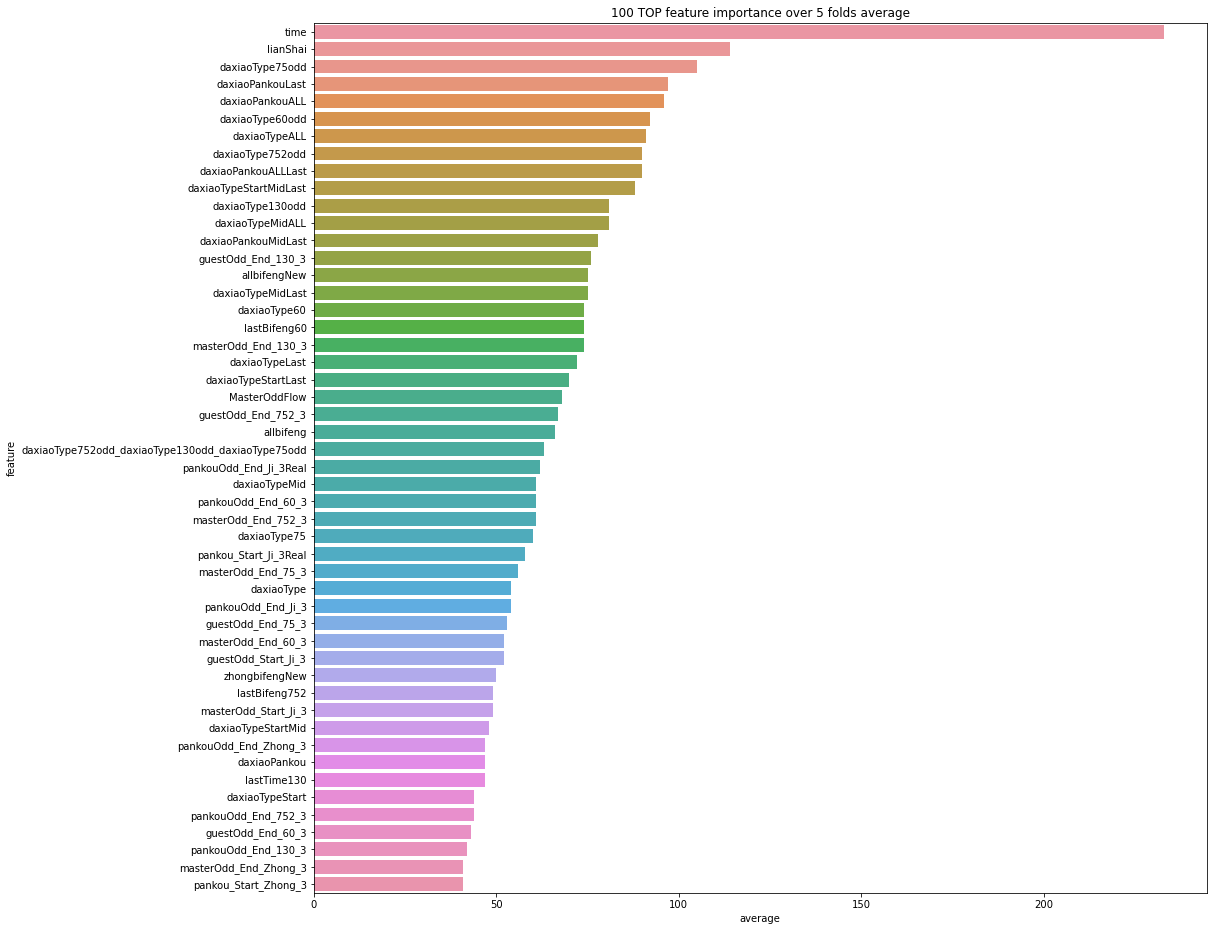

In [32]:
import seaborn as sns
feature_importance_gain=pd.DataFrame()
feature_importance_gain['feature']=columns
feature_importance_gain['fold_1']=clf.feature_importance(importance_type='gain')
feature_importance_gain['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(1)]].mean(axis=1)
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importance_gain.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('100 TOP feature importance over {} folds average'.format(folds.n_splits));

In [33]:
# import seaborn as sns
# sns.set()

# import sweetviz as sv
# # 可以选择目标特征
# my_report = sv.analyze(train, target_feat ='result')
# my_report.show_html()

In [34]:
ss

NameError: name 'ss' is not defined

In [ ]:
train.info()

In [ ]:
data = pd.concat([train_x, train_y], axis=1)

def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['result']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle result if required
    y = data['result'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['result'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)
    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=data, shuffle=False) 

null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    
    feature_scores.append((_f, split_score, gain_score))
 
scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))
 
corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

In [ ]:
for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats     = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    
    gain_feats     = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]

In [ ]:
col = []
for threshold in [60,70, 80 , 90, 95, 99]:
    split_feats     = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    col.append(split_feats)

for i in [0,1,2,3,4,5]:
    import lightgbm as lgb
    from sklearn.metrics import roc_auc_score,accuracy_score
    from sklearn.model_selection import StratifiedKFold
    import gc,joblib
    X = train_x[col[i]]
    y = train_y
    # del train_x,train_y
    # gc.collect()
    params = {'num_leaves': 240,  # 结果对最终效果影响较大，越大值越好，太大会出现过拟合
              'min_data_in_leaf': 30,
              'objective': 'binary',  # 定义的目标函数
              'max_depth': -1,
              'learning_rate': 0.03,
              "min_sum_hessian_in_leaf": 6,
              "boosting": "gbdt",
              "feature_fraction":  0.5992677823884304,  # 提取的特征比率
              "bagging_freq": 4,
              "bagging_fraction": 0.7100471696361973,
              "bagging_seed": 11,
              "lambda_l1": 8.545500456265467e-05,  # l1正则
              'lambda_l2': 5.985747612243422e-07,  # l2正则
              "verbosity": -1,
              "nthread": -1,  # 线程数量，-1表示全部线程，线程越多，运行的速度越快
              'metric': {'auc'},  # 评价函数选择
              "random_state": 2019,  # 随机数种子，可以防止每次运行的结果不一致
              # 'device': 'gpu' ##如果安装的事gpu版本的lightgbm,可以加快运算
              'min_child_samples': 67
              }
    
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'n_jobs': 30,
        'learning_rate': 0.05,
        'num_leaves': 2 ** 6,
        'max_depth': 8,
        'tree_learner': 'serial',
        'colsample_bytree': 0.8,
        'subsample_freq': 1,
        'subsample': 0.8,
        'num_boost_round': 5000,
        'max_bin': 255,
        'verbose': -1,
        'seed': 2021,
        'bagging_seed': 2021,
        'feature_fraction_seed': 2021,
        'early_stopping_rounds': 100,
    }
    
    NFOLDS = 5
    folds = StratifiedKFold(n_splits=NFOLDS)

    columns = X.columns
    splits = folds.split(X, y)
    y_preds = np.zeros(test_x.shape[0])
    y_preds_train  = np.zeros(train_x.shape[0])
    score = 0

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = columns

    for fold_n, (train_index, valid_index) in enumerate(splits):
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        dtrain = lgb.Dataset(X_train, label=y_train)
        dvalid = lgb.Dataset(X_valid, label=y_valid)

        clf = lgb.train(params, dtrain, 300, valid_sets=[
                        dtrain, dvalid], verbose_eval=200, early_stopping_rounds=100)

        feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()

        y_pred_valid = clf.predict(X_valid)
        print(y_pred_valid)
        print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")

        score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
        y_preds += clf.predict(test_x[col[i]]) / NFOLDS

        y_pred_valid = clf.predict(X_valid)
        y_preds_train[valid_index] = y_pred_valid

        del X_train, X_valid, y_train, y_valid
        gc.collect()

    print(f"\nMean AUC = {score}")
    print(f"Out of folds AUC = {roc_auc_score(train_y, y_preds_train)}")
    from sklearn.metrics import roc_auc_score,accuracy_score

    for i in [0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58]:
        test_new = pd.DataFrame({'result':test_y,'predict':y_preds})
        a = test_new[test_new["predict"] >= i]
        pred_labels = np.rint(a['predict'])
        accuracy = accuracy_score(a['result'], pred_labels)
        print(i,"accuarcy: %.2f%%" % (accuracy*100.0),a.shape[0])
        print((a.shape[0] * accuracy * 0.95) - (a.shape[0] * (1-accuracy)))
        
    test2 = test.copy(deep=True)
    test2["result"] = test_y
    test2['predict'] = y_preds
    pred_labels = np.rint(test2['predict'])
    test2["perRes"] = pred_labels
    moneyList = []
    for per in [0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70]:
        def getResultA(x):
            if x >= per:
                return 1
            return 0
        money = 2000
        num = 0
        for i in test2[test2["predict"] >= per].to_dict(orient='records'):
            time = i["time"].split(" ",-1)[1]
            time = int(time.split(":",-1)[0])
            if time >= 7 and time <= 22:
                if getResultA(i["predict"]) == 1.0:
                        num += 1
                        hand = money * 0.023
                        if hand > 10000:
                            hand = 10000
                        money = money - hand
                        odd = i['masterOdd_End_752_3'] + 0.3
                        if i['lastTime130'] > 75:
                            odd = i['masterOdd_End_130_3'] + 0.3

                        if i["result"] == 1: 
                            money = money + hand * (odd + 1)
            if money < 0:
                    break
        print(money,per,num,i)